## Импортируем библиотеки

In [1]:
import pandas as pd
import numpy as np
import itertools

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

import seaborn as sns
import matplotlib.pyplot as plt
#import rfpimp

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

sns.set()
np.random.seed(42)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from sklearn.metrics import accuracy_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from vecstack import stacking
from sklearn.ensemble import (AdaBoostClassifier, GradientBoostingClassifier,
                              RandomForestClassifier, ExtraTreesClassifier)
from sklearn.linear_model import LogisticRegression

## Соотношение классов в тестовой выборке

In [ ]:
clss = pd.read_csv('train.csv')
clss.Outcome.value_counts()

## Загружаем данные

In [74]:
data = pd.read_csv('default_train.csv')
data.head()

,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,DisbursalDate,...,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
0,50578,58400,89.55,67,22807,45,1441,01-01-84,Salaried,03-08-18,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
1,47145,65550,73.23,67,22807,45,1502,31-07-85,Self employed,26-09-18,...,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1
2,53278,61360,89.63,67,22807,45,1497,24-08-85,Self employed,01-08-18,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
3,57513,66113,88.48,67,22807,45,1501,30-12-93,Self employed,26-10-18,...,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1
4,52378,60300,88.39,67,22807,45,1495,09-12-77,Self employed,26-09-18,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1


In [75]:
target='loan_default'

## Смотрим статистики, если необходимо

In [65]:
# data.info()

In [66]:
# data.isnull().sum(axis=0)
#data.apply(lambda x: x.count(), axis=0)

In [4]:
# for col in data.columns:
#     print({col: pd.unique(data[col])})
    
    #можно выкинуть DisbursalDate, MobileNo_Avl_Flag
    #?state_ID, employee_code_ID
    
    #encoding: Employment.Type, PERFORM_CNS.SCORE.DESCRIPTION
    
    # переделать признак во время держания:AVERAGE.ACCT.AGE ~~~DONE, 
    #CREDIT.HISTORY.LENGTH ~~~~DONE
    #'0yrs 0mon'
    
    

In [76]:
avr_act_age = []
cr_hist_len = []

for el in data['AVERAGE.ACCT.AGE']:
    ell = el.replace('yrs','').replace('mon','').split(' ')
    avr_act_age.append(int(ell[0])+int(ell[1])/12)

for el in data['CREDIT.HISTORY.LENGTH']:
    ell = el.replace('yrs','').replace('mon','').split(' ')
    cr_hist_len.append(int(ell[0])+int(ell[1])/12)
    
data['AVERAGE.ACCT.AGE'] = avr_act_age
data['CREDIT.HISTORY.LENGTH'] = cr_hist_len

############

data.drop(['DisbursalDate','MobileNo_Avl_Flag','State_ID','Employee_code_ID',
           'branch_id','supplier_id','manufacturer_id','Current_pincode_ID',
          'AVERAGE.ACCT.AGE','CREDIT.HISTORY.LENGTH'], axis='columns', inplace=True)

#############
#encoding: Employment.Type, PERFORM_CNS.SCORE.DESCRIPTION

empl_dict = {'Salaried':0,
            'Self employed':1,
            'nan':2}

data['Employment.Type']= data['Employment.Type'].apply(lambda x: 0 if x=='Salaried' else\
                (1 if x=='Self employed' else 2))

data['Employment.Type'] = data['Employment.Type'].astype('category')

empl_type = pd.get_dummies(data['Employment.Type'])
data = data.join(empl_type)

############
score_desc = pd.get_dummies(data['PERFORM_CNS.SCORE.DESCRIPTION'], drop_first=True)

score_desc = score_desc.loc[:, (score_desc != 0).any(axis=0)]
data = data.join(score_desc)

############
data.drop(['PERFORM_CNS.SCORE.DESCRIPTION','Employment.Type'], axis='columns', inplace=True)

############
# изменить дату рождения на год
birth = []

for el in data['Date.of.Birth']:
    ell = int(el[-2:])
    birth.append(ell)
data['Date.of.Birth'] = birth

In [74]:
# data.drop(['DisbursalDate','MobileNo_Avl_Flag','State_ID','Employee_code_ID',
#            'branch_id','supplier_id','manufacturer_id','Current_pincode_ID',
#           'AVERAGE.ACCT.AGE','CREDIT.HISTORY.LENGTH'], axis='columns', inplace=True)
# data.head()

,disbursed_amount,asset_cost,ltv,Date.of.Birth,Employment.Type,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,...,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,NO.OF_INQUIRIES,loan_default
0,50578,58400,89.55,01-01-84,Salaried,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,47145,65550,73.23,31-07-85,Self employed,1,0,0,0,0,...,0,0,0,0,1991,0,0,1,0,1
2,53278,61360,89.63,24-08-85,Self employed,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,57513,66113,88.48,30-12-93,Self employed,1,0,0,0,0,...,0,0,0,0,31,0,0,0,1,1
4,52378,60300,88.39,09-12-77,Self employed,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1


In [75]:
#encoding: Employment.Type, PERFORM_CNS.SCORE.DESCRIPTION

# empl_dict = {'Salaried':0,
#             'Self employed':1,
#             'nan':2}

# data['Employment.Type']= data['Employment.Type'].apply(lambda x: 0 if x=='Salaried' else\
#                 (1 if x=='Self employed' else 2))

# data['Employment.Type'] = data['Employment.Type'].astype('category')

# empl_type = pd.get_dummies(data['Employment.Type'])
# data = data.join(empl_type)
# data.head()

,disbursed_amount,asset_cost,ltv,Date.of.Birth,Employment.Type,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,...,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,NO.OF_INQUIRIES,loan_default,0,1,2
0,50578,58400,89.55,01-01-84,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,47145,65550,73.23,31-07-85,1,1,0,0,0,0,...,0,1991,0,0,1,0,1,0,1,0
2,53278,61360,89.63,24-08-85,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,57513,66113,88.48,30-12-93,1,1,0,0,0,0,...,0,31,0,0,0,1,1,0,1,0
4,52378,60300,88.39,09-12-77,1,1,0,0,0,0,...,0,0,0,0,0,1,1,0,1,0


In [76]:
# score_desc = pd.get_dummies(data['PERFORM_CNS.SCORE.DESCRIPTION'], drop_first=True)

# score_desc = score_desc.loc[:, (score_desc != 0).any(axis=0)]
# data = data.join(score_desc)

# data.head()

,disbursed_amount,asset_cost,ltv,Date.of.Birth,Employment.Type,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,...,K-High Risk,L-Very High Risk,M-Very High Risk,No Bureau History Available,Not Scored: More than 50 active Accounts found,Not Scored: No Activity seen on the customer (Inactive),Not Scored: No Updates available in last 36 months,Not Scored: Not Enough Info available on the customer,Not Scored: Only a Guarantor,Not Scored: Sufficient History Not Available
0,50578,58400,89.55,01-01-84,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,47145,65550,73.23,31-07-85,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,53278,61360,89.63,24-08-85,1,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,57513,66113,88.48,30-12-93,1,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,52378,60300,88.39,09-12-77,1,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [77]:
# data.drop(['PERFORM_CNS.SCORE.DESCRIPTION','Employment.Type'], axis='columns', inplace=True)

In [78]:
# # изменить дату рождения на год
# birth = []

# for el in data['Date.of.Birth']:
#     ell = int(el[-2:])
#     birth.append(ell)
# data['Date.of.Birth'] = birth

## Попробуем мультиплицировать

In [ ]:
a = list(data.columns.drop(target))
a_comb = list(itertools.combinations(a,2))

In [ ]:
for i in a_comb:
    data[f'{i[0]}_{i[1]}'] = data[i[0]]*data[i[1]]
data.head(5)

In [ ]:
# если нужна корреляция
#correlation['Outcome'].sort_values(ascending=False)

In [ ]:
# генерируем новые признаки в список
#correlation['Outcome'].values
new_features = correlation.index[correlation[target].values >= 0.2].to_list()
new_features

In [ ]:
data_ = data[['Glucose',
 'BMI',
 'Age',
 'Outcome',
 'Pregnancies_Glucose',
 'Pregnancies_SkinThickness',
 'Pregnancies_BMI',
 'Pregnancies_DiabetesPedigreeFunction',
 'Glucose_BloodPressure',
 'Glucose_SkinThickness',
 'Glucose_BMI',
 'Glucose_DiabetesPedigreeFunction',
 'Glucose_Age',
 'BloodPressure_BMI',
 'BloodPressure_DiabetesPedigreeFunction',
 'SkinThickness_DiabetesPedigreeFunction',
 'SkinThickness_Age',
 'BMI_DiabetesPedigreeFunction',
 'BMI_Age',
 'DiabetesPedigreeFunction_Age']]

In [ ]:
data_.drop(['DiabetesPedigreeFunction_Age',
           'BloodPressure_DiabetesPedigreeFunction',
           'SkinThickness_Age',
           'BMI_DiabetesPedigreeFunction',
           'Age',
           'Glucose',
           'BMI',
           'SkinThickness_DiabetesPedigreeFunction',
           'Pregnancies_BMI',
           'BloodPressure_BMI',
           'Glucose_Age'],
           #'Glucose_BloodPressure',
           #'Pregnancies_DiabetesPedigreeFunction',
           #'Pregnancies_SkinThickness'],
           axis='columns', inplace=True)

In [ ]:
correlation = data_.corr()
plt.figure(figsize=(10,10))
sns.heatmap(correlation, vmax=1, square=True,annot=True)

plt.title('Correlation between different fearures')
plt.show()

In [9]:
lst = [0,1,2,3,4,6,9,10,11,12,13,14,15,22,25,26,30,41]
for col in enumerate(data.columns):
    if col[0] in lst:
        print(col[1])
# 0,1,2,3,4,6,9,10,11,12,13,14,15,22,25,26,30,41

disbursed_amount
asset_cost
ltv
Date.of.Birth
Aadhar_flag
VoterID_flag
PERFORM_CNS.SCORE
PRI.NO.OF.ACCTS
PRI.ACTIVE.ACCTS
PRI.OVERDUE.ACCTS
PRI.CURRENT.BALANCE
PRI.SANCTIONED.AMOUNT
PRI.DISBURSED.AMOUNT
PRIMARY.INSTAL.AMT
DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS
NO.OF_INQUIRIES
2
L-Very High Risk


In [17]:
## data_cut

data_cut = data[['disbursed_amount',
'asset_cost',
'ltv',
'Date.of.Birth',
'Aadhar_flag',
'VoterID_flag',
'PERFORM_CNS.SCORE',
'PRI.NO.OF.ACCTS',
'PRI.ACTIVE.ACCTS',
'PRI.OVERDUE.ACCTS',
'PRI.CURRENT.BALANCE',
'PRI.SANCTIONED.AMOUNT',
'PRI.DISBURSED.AMOUNT',
'PRIMARY.INSTAL.AMT',
'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
'NO.OF_INQUIRIES',
2,
'L-Very High Risk',
                'loan_default']]

In [18]:
data_cut

,disbursed_amount,asset_cost,ltv,Date.of.Birth,Aadhar_flag,VoterID_flag,PERFORM_CNS.SCORE,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,NO.OF_INQUIRIES,2,L-Very High Risk,loan_default
0,50578,58400,89.55,84,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,47145,65550,73.23,85,1,0,598,1,1,1,27600,50200,50200,1991,1,0,0,0,1
2,53278,61360,89.63,85,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,57513,66113,88.48,93,1,0,305,3,0,0,0,0,0,31,0,1,0,1,1
4,52378,60300,88.39,77,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209878,38439,52965,74.58,82,1,0,738,2,2,0,7001,14839,14839,0,0,0,0,0,0
209879,72623,105405,69.73,89,1,0,755,4,4,0,201422,276624,237977,0,0,0,0,0,0
209880,42894,60334,72.93,93,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
209881,73651,100600,74.95,88,0,1,825,1,0,0,0,0,0,1565,0,0,0,0,0


## Готовим данные к модели

In [83]:
# Если мультиплицировали, то заменим data на data_
y = data[target]
data.drop([target], axis='columns', inplace=True) # data_ - это НАШИ ПРИЗНАКИ (x)

In [77]:
# Стандартизация

## MinMax, Standard, none (str)

def stand_data(y,x,standard):
    if standard:
        if standard == 'MinMax':
            scaler = MinMaxScaler()
        elif standard == 'Standard':
            scaler = StandardScaler()
        X = pd.DataFrame(data=scaler.fit_transform(x),columns=x.columns)
        y = y.values
    else:
        X = x
        y = y.values
    X_train, X_test, y_train, y_test = train_test_split(X.values, y, test_size=0.2, random_state=42)#, stratify=y)
    
    return X_train, X_test, y_train, y_test

In [84]:
# Если мультиплицировали, то заменим data на data_

# X_train, X_test, y_train, y_test = stand_data(y,data,None)[0],\
#                                     stand_data(y,data,None)[1],\
#                                     stand_data(y,data,None)[2],\
#                                     stand_data(y,data,None)[3]

# X_train, X_test, y_train, y_test = stand_data(y,data,'MinMax')[0],\
#                                     stand_data(y,data,'MinMax')[1],\
#                                     stand_data(y,data,'MinMax')[2],\
#                                     stand_data(y,data,'MinMax')[3]

X_train, X_test, y_train, y_test = stand_data(y,data,'Standard')[0],\
                                    stand_data(y,data,'Standard')[1],\
                                    stand_data(y,data,'Standard')[2],\
                                    stand_data(y,data,'Standard')[3]

## зададим метрику

In [24]:
from sklearn.metrics import accuracy_score

def compute_metric(clf, X_train=X_train, y_train=y_train, X_test=X_test):
    clf.fit(X_train, y_train)
    y_test_pred = clf.predict(X_test)
    return np.round(accuracy_score(y_test, y_test_pred), 6)
    #return np.round(f1_score(y_test, y_test_pred, average='macro'), 6)

## Лог регрессия

In [58]:
model = LogisticRegression(random_state=0, penalty='l2', solver='lbfgs', n_jobs=-1)
#solver=lbfgs, sag, saga,newton-cg
#penalty l2 l1 none
model = model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('Final prediction score for simple model: %.8f' % accuracy_score(y_test, y_pred))
#0.7826
#0.7829

Final prediction score for simple model: 0.78292875


# Random Forest

In [59]:
clf = RandomForestClassifier().fit(X_train,y_train)
print(clf.score(X_test, y_test))
#print(compute_metric(clf, X_train, y_train, X_test))
#0.771
#0.772

0.7717321390285156


In [26]:
max_depth = [2,3,4,5,6]
for i, depth in enumerate(max_depth):
    clf = RandomForestClassifier(max_depth=depth,
                                criterion='gini').fit(X_train, y_train)
    print(clf.score(X_test, y_test))
    #print(compute_metric(clf, X_train, y_train, X_test))
    print('---')
    #0.783 standard (3)
    #0.763 minmax
    #0.780 без стандартизации

0.7827619887081021
---
0.7827619887081021
---
0.7827619887081021
---
0.7827619887081021
---
0.7827619887081021
---


In [93]:
data.columns

[DecisionTreeClassifier(max_depth=6, max_features='auto', random_state=725570564),
 DecisionTreeClassifier(max_depth=6, max_features='auto',
                        random_state=1482118609),
 DecisionTreeClassifier(max_depth=6, max_features='auto',
                        random_state=1196536411),
 DecisionTreeClassifier(max_depth=6, max_features='auto',
                        random_state=1493013161),
 DecisionTreeClassifier(max_depth=6, max_features='auto', random_state=760254268),
 DecisionTreeClassifier(max_depth=6, max_features='auto', random_state=136600085),
 DecisionTreeClassifier(max_depth=6, max_features='auto', random_state=380974484),
 DecisionTreeClassifier(max_depth=6, max_features='auto', random_state=209230661),
 DecisionTreeClassifier(max_depth=6, max_features='auto', random_state=518127104),
 DecisionTreeClassifier(max_depth=6, max_features='auto', random_state=147847812),
 DecisionTreeClassifier(max_depth=6, max_features='auto',
                        random_state=

Feature ranking:
1. feature 2 (0.186056)
2. feature 0 (0.176562)
3. feature 9 (0.129276)
4. feature 12 (0.059045)
5. feature 15 (0.057698)
6. feature 14 (0.047753)
7. feature 26 (0.037968)
8. feature 13 (0.032910)
9. feature 1 (0.028244)
10. feature 10 (0.027697)
11. feature 25 (0.027246)
12. feature 4 (0.021946)
13. feature 6 (0.020726)
14. feature 41 (0.020293)
15. feature 11 (0.015167)
16. feature 3 (0.013786)
17. feature 22 (0.013774)
18. feature 30 (0.012154)
19. feature 27 (0.009370)
20. feature 28 (0.009365)
21. feature 42 (0.008856)
22. feature 39 (0.007300)
23. feature 24 (0.006070)
24. feature 32 (0.005434)
25. feature 37 (0.005190)
26. feature 31 (0.002919)
27. feature 36 (0.002132)
28. feature 5 (0.001556)
29. feature 21 (0.001455)
30. feature 16 (0.001385)
31. feature 23 (0.001305)
32. feature 20 (0.001290)
33. feature 19 (0.001255)
34. feature 17 (0.001143)
35. feature 48 (0.000949)
36. feature 7 (0.000750)
37. feature 34 (0.000657)
38. feature 38 (0.000657)
39. feature 1

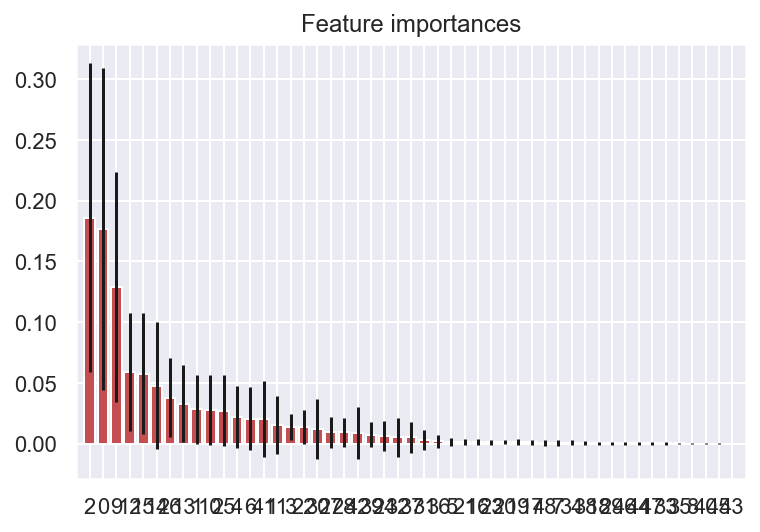

In [91]:
import numpy as np

importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [27]:
params=[10,20,30]
for i, param in enumerate(params):
    clf = RandomForestClassifier(max_depth=4,
                                min_samples_leaf=param,
                                 n_estimators = 1000,
                                random_state=100).fit(X_train, y_train)
    print(clf.score(X_test, y_test))
    #print(compute_metric(clf, X_train, y_train, X_test))

0.7827619887081021
0.7827619887081021
0.7827619887081021


In [30]:
# Итоговая
clf = RandomForestClassifier(max_depth=4,
                                criterion='gini').fit(X_train, y_train)

In [ ]:
??RandomForestClassifier

## Прогноз

In [ ]:
# обучим на всем трейне еще раз
def stand_data_total_nums(y,x,standard):
    if standard:
        if standard == 'MinMax':
            scaler = MinMaxScaler()
        elif standard == 'Standard':
            scaler = StandardScaler()
        X = pd.DataFrame(data=scaler.fit_transform(x),columns=x.columns)
        y = y.values
    else:
        X = x
        y = y.values
    #X_train, X_test, y_train, y_test = train_test_split(X.values, y, test_size=0.2, random_state=42)
    
    return X.values,y

#X_total = stand_data_total_nums(y,data,None)[0]
#y_total = stand_data_total_nums(y,data,None)[1]

clf = RandomForestClassifier(max_depth=3).fit(X_total,y_total)

In [89]:
forc = pd.read_csv('default_test.csv')
forc.head()

,id,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,...,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES
0,1,52603,61300,86.95,67,22807,45,1492,01-06-68,Salaried,...,0,0,0,2608,0,0,0,1yrs 7mon,1yrs 7mon,0
1,2,49478,57010,89.46,67,22807,45,1497,16-08-84,Salaried,...,0,0,0,23309,0,1,0,1yrs 0mon,2yrs 1mon,4
2,3,53503,62100,87.28,67,22807,45,1498,27-02-83,Self employed,...,0,0,0,4982,0,1,0,1yrs 10mon,4yrs 7mon,0
3,4,70017,86760,82.99,67,22807,45,1479,10-08-88,Self employed,...,0,0,0,0,0,0,0,1yrs 9mon,1yrs 9mon,0
4,5,50678,58300,89.88,67,22807,45,1474,01-06-77,Self employed,...,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0


In [90]:
# делаем такую же предобработку

avr_act_age = []
cr_hist_len = []

for el in forc['AVERAGE.ACCT.AGE']:
    ell = el.replace('yrs','').replace('mon','').split(' ')
    avr_act_age.append(int(ell[0])+int(ell[1])/12)

for el in forc['CREDIT.HISTORY.LENGTH']:
    ell = el.replace('yrs','').replace('mon','').split(' ')
    cr_hist_len.append(int(ell[0])+int(ell[1])/12)
    
forc['AVERAGE.ACCT.AGE'] = avr_act_age
forc['CREDIT.HISTORY.LENGTH'] = cr_hist_len

############

forc.drop(['DisbursalDate','MobileNo_Avl_Flag','State_ID','Employee_code_ID',
           'branch_id','supplier_id','manufacturer_id','Current_pincode_ID',
          'AVERAGE.ACCT.AGE','CREDIT.HISTORY.LENGTH'], axis='columns', inplace=True)

############
#encoding: Employment.Type, PERFORM_CNS.SCORE.DESCRIPTION

empl_dict = {'Salaried':0,
            'Self employed':1,
            'nan':2}

forc['Employment.Type']= forc['Employment.Type'].apply(lambda x: 0 if x=='Salaried' else\
                (1 if x=='Self employed' else 2))

forc['Employment.Type'] = forc['Employment.Type'].astype('category')

empl_type = pd.get_dummies(forc['Employment.Type'])
forc = forc.join(empl_type)

############
score_desc = pd.get_dummies(forc['PERFORM_CNS.SCORE.DESCRIPTION'], drop_first=True)
forc = forc.join(score_desc)

############
forc.drop(['PERFORM_CNS.SCORE.DESCRIPTION','Employment.Type'], axis='columns', inplace=True)

############
# изменить дату рождения на год
birth = []

for el in forc['Date.of.Birth']:
    ell = int(el[-2:])
    birth.append(ell)
forc['Date.of.Birth'] = birth

forc.drop(['id'], axis='columns', inplace=True)

def stand_data_prediction(x,standard,x_forcasted):
    if standard:
        if standard == 'MinMax':
            scaler = MinMaxScaler().fit(x)
        elif standard == 'Standard':
            scaler = StandardScaler().fit(x)
        return pd.DataFrame(data=scaler.transform(x_forcasted), columns=x_forcasted.columns)

    else:
        return x_forcasted

    
X_forcasted = stand_data_prediction(data,'Standard',forc)

# forc_cut = X_forcasted[['disbursed_amount',
# 'asset_cost',
# 'ltv',
# 'Date.of.Birth',
# 'Aadhar_flag',
# 'VoterID_flag',
# 'PERFORM_CNS.SCORE',
# 'PRI.NO.OF.ACCTS',
# 'PRI.ACTIVE.ACCTS',
# 'PRI.OVERDUE.ACCTS',
# 'PRI.CURRENT.BALANCE',
# 'PRI.SANCTIONED.AMOUNT',
# 'PRI.DISBURSED.AMOUNT',
# 'PRIMARY.INSTAL.AMT',
# 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
# 'NO.OF_INQUIRIES',
# 2,
# 'L-Very High Risk']]

In [70]:
#fc = forc.columns.to_list()
for col in forc.columns:
    if col not in data.columns:
        print(col)

id


In [82]:
??model

In [91]:
#prediction = clf.predict(forc_cut.values)
prediction_3 = model.predict(X_forcasted.values)

In [92]:
prediction_3

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [41]:
# forc = pd.read_csv('defatest.csv')
#submission = [(num, pred) for nums,preds in zip(forc['Id'],prediction)]
#submission
#[[i,j] for i,j in zip(forc['Id'].values,prediction)]
#[f'{i},{j}' for i,j in zip(forc['Id'].values,prediction)]

prediction_2 = [0 for i in prediction]

In [93]:
sample_submission = pd.read_csv('default_sample_submission.csv')
sample_submission.head()

,id,loan_default
0,1,1
1,2,1
2,3,1
3,4,1
4,5,1


In [94]:
import csv
# Сохраняем предсказания в отдельный файл, он будет доступен для скачивания справа 
sample_submission['loan_default'] = prediction_3
sample_submission.to_csv('submission_kaggle_3.csv', index=False)
sample_submission.head(10)

,id,loan_default
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
5,6,0
6,7,0
7,8,0
8,9,0
9,10,0


In [96]:
pd.unique(sample_submission['loan_default'])

array([0, 1], dtype=int64)

In [98]:
sample_submission[sample_submission['loan_default']==1]

,id,loan_default
614,615,1
753,754,1
887,888,1
955,956,1
1298,1299,1
...,...,...
19589,19590,1
20499,20500,1
20791,20792,1
20809,20810,1


In [42]:
import csv
# Сохраняем предсказания в отдельный файл, он будет доступен для скачивания справа 

sample_submission['loan_default'] = prediction_2
sample_submission.to_csv('submission_kaggle_2.csv', index=False)
sample_submission.head(10)

,id,loan_default
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
5,6,0
6,7,0
7,8,0
8,9,0
9,10,0


## Опорные вектора

In [ ]:
#clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
#clf.fit(X, y)

svm = SVC(kernel='linear', 
          C=1.0, 
          random_state=1).fit(X_train, y_train)

y_pred = svm.predict(X_test)
print('Final prediction score for meta model: %.8f' % accuracy_score(y_test, y_pred))

In [ ]:
svm_rbf = SVC(kernel='rbf', 
              random_state=1, 
              gamma=0.10, 
              C=10.0).fit(X_train, y_train)
y_pred = svm_rbf.predict(X_test)
print('Final prediction score for meta model: %.8f' % accuracy_score(y_test, y_pred))

In [ ]:
??SVC

## Соседи

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5, 
                           p=2, 
                           metric='minkowski').fit(X_train, y_train)

y_pred = knn.predict(X_test)
print('Final prediction score for meta model: %.8f' % f1_score(y_test, y_pred))

# GB

In [87]:
clf = GradientBoostingClassifier(
    n_estimators=100, 
    learning_rate=0.1,
    max_depth=3,
    min_samples_split=2,
    min_samples_leaf=1,
    subsample=1,
    max_features=None,
    random_state=42).fit(X_train, y_train)
y_pred = clf.predict(X_test) 
print('Final prediction score for meta model: %.8f' % accuracy_score(y_test, y_pred))

Final prediction score for meta model: 0.78359578


## Бустинг

In [88]:
# evaluate the model
model = HistGradientBoostingClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
#print('F1: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
# fit the model on the whole dataset
model = HistGradientBoostingClassifier().fit(X_train, y_train)
y_pred = model.predict(X_test)
print('Final prediction score for meta model: %.8f' % accuracy_score(y_test, y_pred))

Final prediction score for meta model: 0.78371489


In [86]:
xgb = XGBClassifier(random_state=0, n_jobs=-1, learning_rate=0.1, 
                  n_estimators=100, max_depth=3, 
              use_label_encoder=False, eval_metric='logloss').fit(X_train,y_train)

y_pred = xgb.predict(X_test)
print('Final prediction score for meta model: %.8f' % accuracy_score(y_test, y_pred))
#0.78341

Final prediction score for meta model: 0.78342902


In [85]:
from lightgbm import LGBMClassifier

# evaluate the model
model = LGBMClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

# fit the model on the whole dataset
model = LGBMClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print('Final prediction score for meta model: %.8f' % accuracy_score(y_test, y_pred))
#0.78345

Final prediction score for meta model: 0.78333373


In [62]:
from catboost import CatBoostClassifier


model = CatBoostClassifier(verbose=0, n_estimators=100)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

model = CatBoostClassifier(verbose=0, n_estimators=100)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print('Final prediction score for meta model: %.8f' % accuracy_score(y_test, y_pred))
#

Final prediction score for meta model: 0.02356975


# Стекинг

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from vecstack import stacking
from sklearn.ensemble import (AdaBoostClassifier, GradientBoostingClassifier,
                              RandomForestClassifier, ExtraTreesClassifier)
from sklearn.linear_model import LogisticRegression

In [43]:
models = [
#    KNeighborsClassifier(n_neighbors=5,
#                        n_jobs=-1),
    GradientBoostingClassifier(
                                n_estimators=1000, 
                                learning_rate=0.1,
                                max_depth=3,
                                min_samples_split=2,
                                min_samples_leaf=1,
                                subsample=1,
                                max_features=None,
                                random_state=42),
    
#     LogisticRegression(random_state=0, penalty='none', solver='saga', n_jobs=-1),
        
    RandomForestClassifier(random_state=0, n_jobs=-1, 
                            max_depth=3),
        
    XGBClassifier(random_state=0, n_jobs=-1, learning_rate=0.1, 
                  n_estimators=1000, max_depth=3, use_label_encoder=False, eval_metric='logloss'),
    
    AdaBoostClassifier(random_state=0, learning_rate=0.1),
    
    ExtraTreesClassifier(random_state=0,)
    
    #SVG
]

In [44]:
S_train, S_test = stacking(models,                   
                           X_train, y_train, X_test,   
                           regression=False, 
                           mode='oof_pred_bag', 
                           needs_proba=False,
                           save_dir=None, 
                           metric=accuracy_score, 
                           n_folds=4, 
                           stratified=True,
                           shuffle=True,  
                           random_state=0,    
                           verbose=2)

task:         [classification]
n_classes:    [2]
metric:       [accuracy_score]
mode:         [oof_pred_bag]
n_models:     [5]

model  0:     [GradientBoostingClassifier]


KeyboardInterrupt: 

In [ ]:
model_meta = XGBClassifier(random_state=0, n_jobs=-1, learning_rate=0.1, 
                      n_estimators=100, max_depth=3, use_label_encoder=False, eval_metric='logloss')
    
model_meta = model_meta.fit(S_train, y_train)
y_pred_meta = model_meta.predict(S_test)
print('Final prediction score for meta model: %.8f' % f1_score(y_test, y_pred_meta))

#0.583
#0.649
#0.683
#0.713

In [ ]:
model = RandomForestClassifier(random_state=0, n_estimators=100, max_depth=3)
model = model.fit(S_train, y_train)
y_pred = model.predict(S_test)
print('Final prediction score for simple model: %.8f' % f1_score(y_test, y_pred))

#0.685
#0.685
#0.685

In [ ]:
model = LogisticRegression(random_state=0, penalty='none', solver='saga', n_jobs=-1)
#solver=lbfgs, sag, saga,newton-cg
#penalty l2 l1 none
model = model.fit(S_train, y_train)
y_pred = model.predict(S_test)
print('Final prediction score for simple model: %.8f' % f1_score(y_test, y_pred))